# Projet numérique : câble sous-marin

Par Narjis El Amraoui et Rania Fathi

### Préambule:

In [81]:
import numpy as np
import math
import matplotlib.pyplot as plt

A=0
B=500
N=101
Delta = (B-A)/(N-1)
discretization_indexes = np.arange(N)
discretization = discretization_indexes*Delta

mu = -5
a = 50
sigma2 = 12

observation_indexes = np.array([0,20,40,60,80,100])
observation = observation_indexes * Delta

depth = np.array([50,-4,-12.8,-1,-6.5,0])

unknown_indexes=np.array(list(set(discretization_indexes)-set(observation_indexes)))
unknown_positions = unknown_indexes * Delta

## Questions théoriques: 

1 - C'est la loi forte des grands nombres qui nous autorise à estimer l’espérance conditionnelle par la moyenne empirique de simulations conditionnelles.


2 - Comme démontré dans le cours de probabilités 4, le vecteur des composantes de __Z__ correspondant aux points de discrétisation sans observation connaissant les valeurs prises par les composantes aux sites d’observation suit une loi normale. 
En notant X le vecteur aléatoire des composantes non observées, et Y celui des observations, et y les valeurs des observations, on a que __Z__ suit une loi normale d'espérance $m_{X|Y=y} =  m_X + C_{X,Y}C_Y^{-1}(y-m_Y)$ et de matrice de covariance $ C_X - C_{X,Y}C_Y^{-1}C_{Y,X}$


3 - Si Y = (Y1, . . . , Yp) est un vecteur de composantes gaussiennes indépendantes, toutes d’espérance nulle et de variance 1, alors le vecteur Z = m + RY suit une loi normale d'espérance m et de matrice de covariance $R^{t}R$ , en effet : 
$\Phi_{Z}(u)= \textbf{E}(e^{i<u, m + RY>})  \\
\Phi_{Z}(u)= \textbf{E}(e^{i<u,m>} e^{<^t Ru, Y>}) \\ 
\Phi_{Z}(u)= e^{i<u,m>}\textbf{E}( e^{<^{t}Ru, Y>}) \\
\Phi_{Z}(u)= e^{i<u,m>} \Phi_{Y}(^{t}Ru)$



Et Y suit une loi normale, d'espérance (0,...,0) et de covariance l'identité, d'où: 
$\Phi_{Y}(u) = e^{i<u,0> - \frac{1}{2}<u,u>} \\
 \Phi_{Y}(^{t}Ru) = e^{- \frac{1}{2}<^{t}Ru,^{t}Ru>}\\
 \Phi_{Y}(^{t}Ru) = e^{- \frac{1}{2}<u,R^{t}Ru>}$

On en déduit donc que :  
$\Phi_{Y}(u) = e^{i<u,m> - \frac{1}{2}<u,R^{t}Ru>} $


La fonction caractéristique déterminant de façon unique la loi suivie par Z, on a bien le résultat annoncé. 
Reste que pour la suite du projet, il sera nécessaire de décomposer la matrice de covariance de Z - notons la C - sous la forme $R^{t}R$. 

On cherche R triangulaire inférieure telle que $C=R^tR$. On note $c_{ij}$ les coefficients de la matrice C, et $r_{ij}$ ceux de R. On a donc : 
$c_{ij} = \sum _{k=0}^{min(i,j)} r_{ik} r_{jk} $ car $r_{ij} = 0$ si $j \geq i$ 


Comme C est symétrique, on peut se limiter aux $c_{ij} = \sum _{k=0}^{i} r_{ik} r_{jk} $ où $i \leq j$

On détermine les coefficients de R par récurrence: 

* Pour i = 1:
    * j =1: $c_{11} = r_{11}^2$ donc $r_{11}= \sqrt{c_{11}}$
    * j>1: $c_{1j} = r_{11}r_{j1}$ donc $r_{j1} = \frac{c_{1j}}{\sqrt{c_{11}}}$ 
* Pour i > 1, en supposant les i-1 premières colonnes connues: 
    * $c_{ii} = \sum _{k=0}^{i-1} r_{ik} ^2 + r_{ii}^2$ donc $r_{ii}= \sqrt{c_{ii} - \sum _{k=0}^{i-1} r_{ik} r_{ji}}$ 
    * $c_{ij} = \sum _{k=0}^{i-1} r_{ik} r_{jk} + r_{ii}r_{ji}$ donc $r_{ji}= \frac{c_{ij} - \sum _{k=0}^{i-1} r_{ik} r_{jk}} {r_{ii}} 
    $
    
    
Toutes les grandeurs ainsi définies ont un sens car C est définie positive 

4 - On en déduit l'algorithme de simulation conditionnel suivant: 

In [82]:
def vecteur_gaussien(moy_Z, R): 
    """Simulation numérique de Z qui suit N(moy_Z, RtR) en fonction de R et moy_Z (l'espérance conditionelle)"""
    taille=N-len(observation_indexes) 
    moy = np.zeros(1)
    cov = np.identity(1)
    Y = np.random.multivariate_normal(moy, cov, taille)
    Z = moy_Z + np.dot(R, Y)
    return Z #Z_conditionnel est de taille N-6

def matrice_R(C):
    """On cherche à trouver R telle que Cov_Z = RtR où R est 
    triangulaire inférieure (théorème de Cholesky prouvé par 
    analyse-synthèse) on peut trouver les coefficients d'un tel
    R grâce à l'algorithme suivant"""
    
    taille=N-len(observation_indexes)
    
    R = np.zeros((taille, taille))
    
    #D'abord la première colonne ie pour i=0
    R[0][0] = math.sqrt(C[0][0])
    for j in range(1, taille):
        R[j][0] = C[0][j]/R[0][0]
        
    #Puis pour les autres colonnes qui se calculent par récurrence sur les colonnes
    for i in range(1,taille):
        sommeii=0
        for k in range(0,i):
            sommeii+=R[i][k]**2
        R[i][i] = math.sqrt(C[i][i]-sommeii)
        for j in range(0, i):
            sommeij=0
            for k in range(0,i):
                sommeij+=R[i][k]*R[j][k]
            R[j][i] =  (C[i][j]-sommeij)/R[i][i]
    return R

In [83]:
### Test vecteur_gaussien
Y = np.random.multivariate_normal(np.zeros(1), np.identity(1), 95)
moy = np.array([[0]]*95)
Z = vecteur_gaussien(moy, np.identity(95))



## Implémentation: 

#### Question 1

In [84]:
def covariance(distance, a, sigma2): 
    #np.exp renvoie bien la matrice des exp des éléments plutôt que l'exp de la matrice
    return sigma2*np.exp(-distance/a) 

**Question 2 :** On calcule la matrice de distance:  

In [85]:
def distance():
    return np.array([[Delta * abs(i-j) for i in range(N)] for j in range(N)])

**Question 3 :** On calcule la matrice de covariance de __Z__

In [86]:
cov_Z = covariance(distance(), a, sigma2) 

**Question 4 :** Puis celles entre les observations, les observations et les inconnues, et les inconnues:

In [87]:
cov_obs = np.array([[cov_Z[i,j] for i in observation_indexes] for j in observation_indexes])
cov_obs_inc = np.array([[cov_Z[i,j] for i in observation_indexes] for j in  unknown_indexes])
cov_inc = np.array([[cov_Z[i,j] for i in unknown_indexes] for j in unknown_indexes ])

**Question 5 :** On calcule l’espérance conditionnelle des composantes non observées connaissant les observations :

In [88]:
# Calcul de l'espérance conditionnelle:
m_inc = np.array([mu for i in unknown_indexes])
m_obs = np.array([mu for i in observation_indexes])

moy_Z_conditionnelle = m_inc + np.dot(np.dot(cov_obs_inc, np.linalg.inv(cov_obs)), depth - m_obs)
#Il faut que le vecteur espérance conditionnelle soit une colonne et pas une lignes
moy_Z_conditionnelle_colonne = np.array([[el] for el in moy_Z_conditionnelle]) 

Que l'on représente avec les données: 

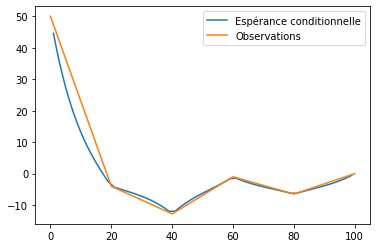

In [89]:
plt.plot(unknown_indexes, moy_Z_conditionnelle, label="Espérance conditionnelle")
plt.plot(observation_indexes, depth, label="Observations")
plt.legend()
plt.show()
    

**Question 6 :** On calcule la matrice de variance conditionnelle et on extrait sa diagonale: 

In [90]:
cov_Z_conditionnelle = cov_inc - np.dot(np.dot(cov_obs_inc,np.linalg.inv(cov_obs)),cov_obs_inc.T)
cov_Z_conditionnelle_diag = np.array([cov_Z_conditionnelle[i,i] for i in range(len(unknown_indexes))]) 


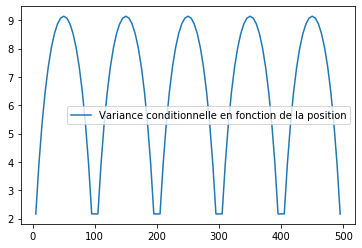

In [91]:
plt.plot(unknown_positions,cov_Z_conditionnelle_diag, label = "Variance conditionnelle en fonction de la position" )
plt.legend()
plt.show()

On remarque que la variance est quasi-nulle tous les 100m parce que ces points sont proches des observations, on sait donc déjà que leur profondeur  va peu varier, étant nécessairement proche de la profondeur des points d'observations.

 **Question 7:**

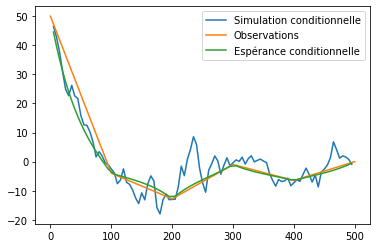

In [92]:
Z_conditionnel = vecteur_gaussien(moy_Z_conditionnelle_colonne, matrice_R(cov_Z_conditionnelle))



plt.figure()

plt.plot(unknown_positions, Z_conditionnel, label="Simulation conditionnelle") 
plt.plot(observation, depth, label="Observations")
plt.plot(unknown_positions, moy_Z_conditionnelle, label="Espérance conditionnelle")
plt.legend()
plt.show()



On remarque que la simulation fluctue de façon non négligeable, et donc, que la longueur du câble trouvé par simulation sera plus importante que celle obtenue grâce à l'espérance conditionnelle. Néanmoins, les profils produits par la simulation et par l'espérance conditonnelle ont bien la même allure.   

 **Question 8:**

In [93]:
def longueur_cable(Z_gras, pas):
    return sum(math.sqrt(pas**2 +(Z_gras[k]-Z_gras[k-1])**2) for k in range(1,N))

**Question 9:** 

On reconstitue le Z entier avec la simulation conditionnelle et les données observées:


In [94]:
R = matrice_R(cov_Z_conditionnelle)
def Z_gras():
    Z_gras = np.array([[0.]]*N)
    c=0
    Z_condi = vecteur_gaussien(moy_Z_conditionnelle_colonne, R)
    for i in unknown_indexes:
        Z_gras[i] = Z_condi[c]
        c+=1
    c=0
    for i in observation_indexes:
        Z_gras[i] = depth[c]
        c+=1
    return Z_gras

#Test longueur: 
longueur_cable(Z_gras(), Delta)

580.5531991444243

On reconstitue aussi le vecteur espérance en entier:

In [95]:

moy_Z_gras = np.array([[0.]]*N)
c=0
for i in unknown_indexes:
    moy_Z_gras[i] = moy_Z_conditionnelle_colonne[c]
    c+=1
c=0
for i in observation_indexes:
    moy_Z_gras[i] = depth[c]
    c+=1

In [96]:
n =100
def sim_plusieurs_essais(n):
    liste_longueurs=[]
    for k in range(n):
        liste_longueurs.append(longueur_cable(Z_gras(), Delta))
    return liste_longueurs

def moyenne(liste):
    if len(liste)==0:
        return 0
    return sum(t for t in liste)/len(liste)



In [97]:
sim_multiples = sim_plusieurs_essais(n)
L_estimee = moyenne(sim_multiples)
L_esp_cond = longueur_cable(moy_Z_gras, Delta)
print(L_estimee, L_esp_cond)



577.5355883387756 517.0359216380282


On retrouve bien des valeurs similaires, mais comme la variance est élevée lorsqu'on s'éloigne des observations et que N l'est aussi, on arrive très vite à de grandes distances parcourues entre 2 points d'observations par rapport à la distance optimale de l'espérance conditionnelle (quasiment une ligne droite). En effet, si pour plusieurs simulations on peut approcher l'espérance conditionnelle, ce n'est pas le cas pour la moyenne de la longueur où il n'y a pas de compensation sur les longues distances parcourues en moyenne puisqu'on passe par des valeurs absolues.

**Question 10:**

In [98]:
pas = 10

def liste(n): 
    return np.arange(0,n + pas, pas)
sim_multiples_pas= [sim_multiples[k*pas:(k+1)*pas + 1] for k in range(n//pas)] #==> [[10 sim], [10 sim], ..., [10 sim]]

def liste_Mn(pas):
    liste_Sn = [0.]
    liste_Mn = []
    c = 0
    for k in range(1,len(liste(n))):
        a = liste_Sn[-1]+ sum(t for t in sim_multiples_pas[c]) # à chaque fois on ajoute 'pas' simulations plutôt que de tout recalculer
        liste_Sn.append(a)
        c += 1
    for k in range(1, len(liste(n))): 
        liste_Mn.append(liste_Sn[k]/liste(n)[k])
    return liste_Mn

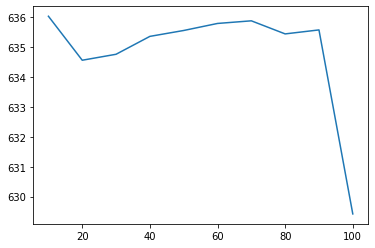

In [99]:
plt.figure()
plt.plot(liste(100)[1:], liste_Mn(pas), label="Moyenne des longueurs de câbles en fonction du nombre de simulation")
plt.show()

**Question 11:**

Text(0.5, 1.0, 'Histogramme des longueurs de câbles générées')

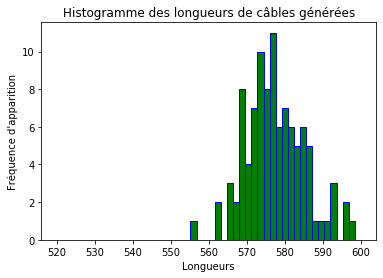

In [100]:
bins_histo = 50
histo = plt.hist(sim_multiples, range = (520, 600), bins = bins_histo, color = 'green', edgecolor = 'blue')
plt.xlabel('Longueurs')
plt.ylabel("Fréquence d'apparition")
plt.title('Histogramme des longueurs de câbles générées')


**Question 12:**


Première méthode: On utilise l'histogramme déjà réalisé - mais elle est assez peu précise

In [101]:
def plus_probable(occurences):
    indexe = 0
    for i in range(len(occurences)):
        if occurences[i] > occurences[indexe]:
            indexe = i 
    return indexe

valeurs = [t for t,c in zip(histo[1], range(bins_histo)) if histo[0][c] != 0]
occurences = [ c for c in histo[0] if c != 0]

def intervalle_confiance():
    proba = 0.
    L = {}
    indexe = plus_probable(occurences) #On choisit la tranche de l'histogramme avec le plus d'occurences,
    #ce qui nous donne notre indexe de départ
    while proba < .95:
        #à chaque fois qu'on retire l'indexe retenu dans l'intervalle, on compare
        #les deux indexes qui l'entouraient pour ne pas avoir de trous dans l'intervalle,
        #ce qui correspond toujours à indexe et indexe+1 (en décrémentant indexe à indexe-1 quand il a été retenu pour ne pas sortir de la liste)
        if occurences[indexe]>=occurences[indexe+1]: 
            indexe_retenu=indexe
            indexe=indexe-1
        else:
            indexe_retenu=indexe+1
        L[valeurs[indexe_retenu]] = occurences[indexe_retenu]
        proba += occurences[indexe_retenu]/n 
        valeurs.pop(indexe_retenu)
        occurences.pop(indexe_retenu)
    return [min(L.keys()), max(L.keys())]
intervalle_confiance()

[555.2, 596.8]

Deuxième méthode: On assimile la distribution à une gaussienne et on applique la formule $moy \pm Z_{\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$

In [102]:
def int_confiance_m2(n): 
    moy = L_estimee
    ecart_type = math.sqrt(sum((x-moy)**2 for x in sim_multiples)/n)
    return np.array([moy - 1.96 * ecart_type/math.sqrt(n),moy + 1.96 * ecart_type/math.sqrt(n)])
int_confiance_m2(n)

array([575.98881715, 579.08235953])

**Question 13:**

In [103]:
def estimation_proba_sup(longueur, n):
    L = sim_multiples
    compteur = sum(1 for k in range(n) if L[k]>=longueur)
    return compteur/n

estimation_proba_sup(525, n)


1.0

En effet, la moyenne qu'on obtient avec les simulations tourne autour de 570 et ne semble pas diminuer avec N (puisqu'on augmente les possibilités de s'éloigner des points d'observation en affectant à plus de points une hauteur qui suit une loi gaussienne). D'où la probabilité d'obtenir une longueur supérieure à 525m égale à 1 avec notre simulation.

**Question 14:**


### On reprend les fonctions précédentes pour n = 1000

In [104]:
n = 1000
sim_multiples = sim_plusieurs_essais(n) 



In [105]:
L_estimee = moyenne(sim_multiples)
L_esp_cond = longueur_cable(moy_Z_gras, Delta)
print(L_estimee, L_esp_cond)


576.4413467321071 517.0359216380282


Text(0.5, 1.0, 'Histogramme des longueurs de câbles générées pour n = 1000')

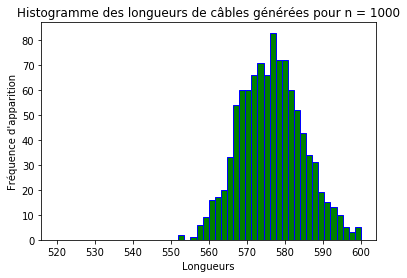

In [106]:

histo = plt.hist(sim_multiples, range = (520, 600), bins = bins_histo, color = 'green', edgecolor = 'blue')
plt.xlabel('Longueurs')
plt.ylabel("Fréquence d'apparition")
plt.title('Histogramme des longueurs de câbles générées pour n = 1000')

In [107]:
Intervalles de confiance à 95%: 

SyntaxError: invalid syntax (<ipython-input-107-290c0099bea9>, line 1)

In [108]:
valeurs = [t for t,c in zip(histo[1], range(bins_histo)) if histo[0][c] != 0]
occurences = [ c for c in histo[0] if c != 0]
print(intervalle_confiance(), int_confiance_m2(n))

[560.0, 592.0] [575.92941758 576.95327588]


Probabilité de dépasser les 525m: 

In [109]:
estimation_proba_sup(525, n)


1.0

### On reprend les fonctions précédentes pour n = 10000

In [110]:
n = 10000
sim_multiples = sim_plusieurs_essais(n)

In [111]:
L_estimee = moyenne(sim_multiples)
L_esp_cond = longueur_cable(moy_Z_gras, Delta)
print(L_estimee, L_esp_cond)


576.5844573837998 517.0359216380282


Text(0.5, 1.0, 'Histogramme des longueurs de câbles générées')

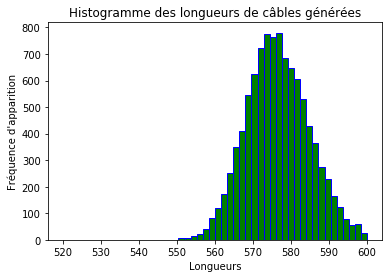

In [112]:
histo = plt.hist(sim_multiples, range = (520, 600), bins = bins_histo, color = 'green', edgecolor = 'blue')
plt.xlabel('Longueurs')
plt.ylabel("Fréquence d'apparition")
plt.title('Histogramme des longueurs de câbles générées')

In [113]:
valeurs = [t for t,c in zip(histo[1], range(bins_histo)) if histo[0][c] != 0]
occurences = [ c for c in histo[0] if c != 0]
print(intervalle_confiance(), int_confiance_m2(n))



[560.0, 592.0] [576.42127718 576.74763759]


Probabilité de dépasser 525m: 

In [114]:
estimation_proba_sup(525, n)


1.0